In [2]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import dates as mpl_dates
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import random

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
random.seed(123)
import os

from sklearn.model_selection import train_test_split



## Data Checks

In [3]:
#load data
df = pd.read_csv('data/merge_raw_data_Teledyne/calibration_data_sets/merged_Teledyne_data_weather_data_ENE00950.csv', parse_dates=['DataDate'])
df


,DataDate,PM2_5,PM10,RH,Temp,PM2.5
0,2023-10-01 19:07:00,5.0,5.0,100.50,26.61,7.374148
1,2023-10-01 19:08:00,5.0,5.0,100.50,26.63,7.327665
2,2023-10-01 19:09:00,5.0,5.0,100.50,26.66,7.248282
3,2023-10-01 19:10:00,5.0,5.0,100.50,26.65,7.182676
4,2023-10-01 19:11:00,5.0,5.0,100.50,26.64,7.170102
...,...,...,...,...,...,...
49383,2023-11-16 13:45:00,2.0,2.0,64.86,33.48,8.077689
49384,2023-11-16 13:46:00,2.0,2.0,64.28,33.71,8.080121
49385,2023-11-16 13:47:00,2.0,2.0,63.57,33.77,8.092282
49386,2023-11-16 13:48:00,3.0,4.0,64.45,33.74,8.092282


In [4]:
df.isna().sum()

DataDate    0
PM2_5       0
PM10        0
RH          0
Temp        0
PM2.5       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49388 entries, 0 to 49387
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DataDate  49388 non-null  datetime64[ns]
 1   PM2_5     49388 non-null  float64       
 2   PM10      49388 non-null  float64       
 3   RH        49388 non-null  float64       
 4   Temp      49388 non-null  float64       
 5   PM2.5     49388 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 2.3 MB


In [6]:
df.describe()

,DataDate,PM2_5,PM10,RH,Temp,PM2.5
count,49388,49388.000000,49388.000000,49388.000000,49388.000000,49388.000000
mean,2023-10-27 01:47:59.814124800,12.604988,13.932997,94.664495,28.467808,15.137763
min,2023-10-01 19:07:00,0.000000,0.000000,62.370000,23.370000,0.000000
25%,2023-10-17 02:25:45,7.000000,7.000000,88.300000,26.540000,9.600298
50%,2023-10-28 11:02:30,10.000000,11.000000,100.500000,27.850000,13.139130
75%,2023-11-06 17:15:15,16.000000,18.000000,100.500000,30.420000,18.554248
max,2023-11-16 13:49:00,126.000000,144.000000,100.600000,34.710000,69.265610
std,NaN,9.214099,10.608177,8.577820,2.345334,7.967569


In [7]:
df.shape

(49388, 6)

In [8]:
df.columns

Index(['DataDate', 'PM2_5', 'PM10', 'RH', 'Temp', 'PM2.5'], dtype='object')

In [9]:
df.duplicated().sum()

0

In [10]:
df.nunique()

DataDate    49388
PM2_5         151
PM10          172
RH           1197
Temp         1095
PM2.5       45952
dtype: int64

In [11]:
## define numerical columes
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

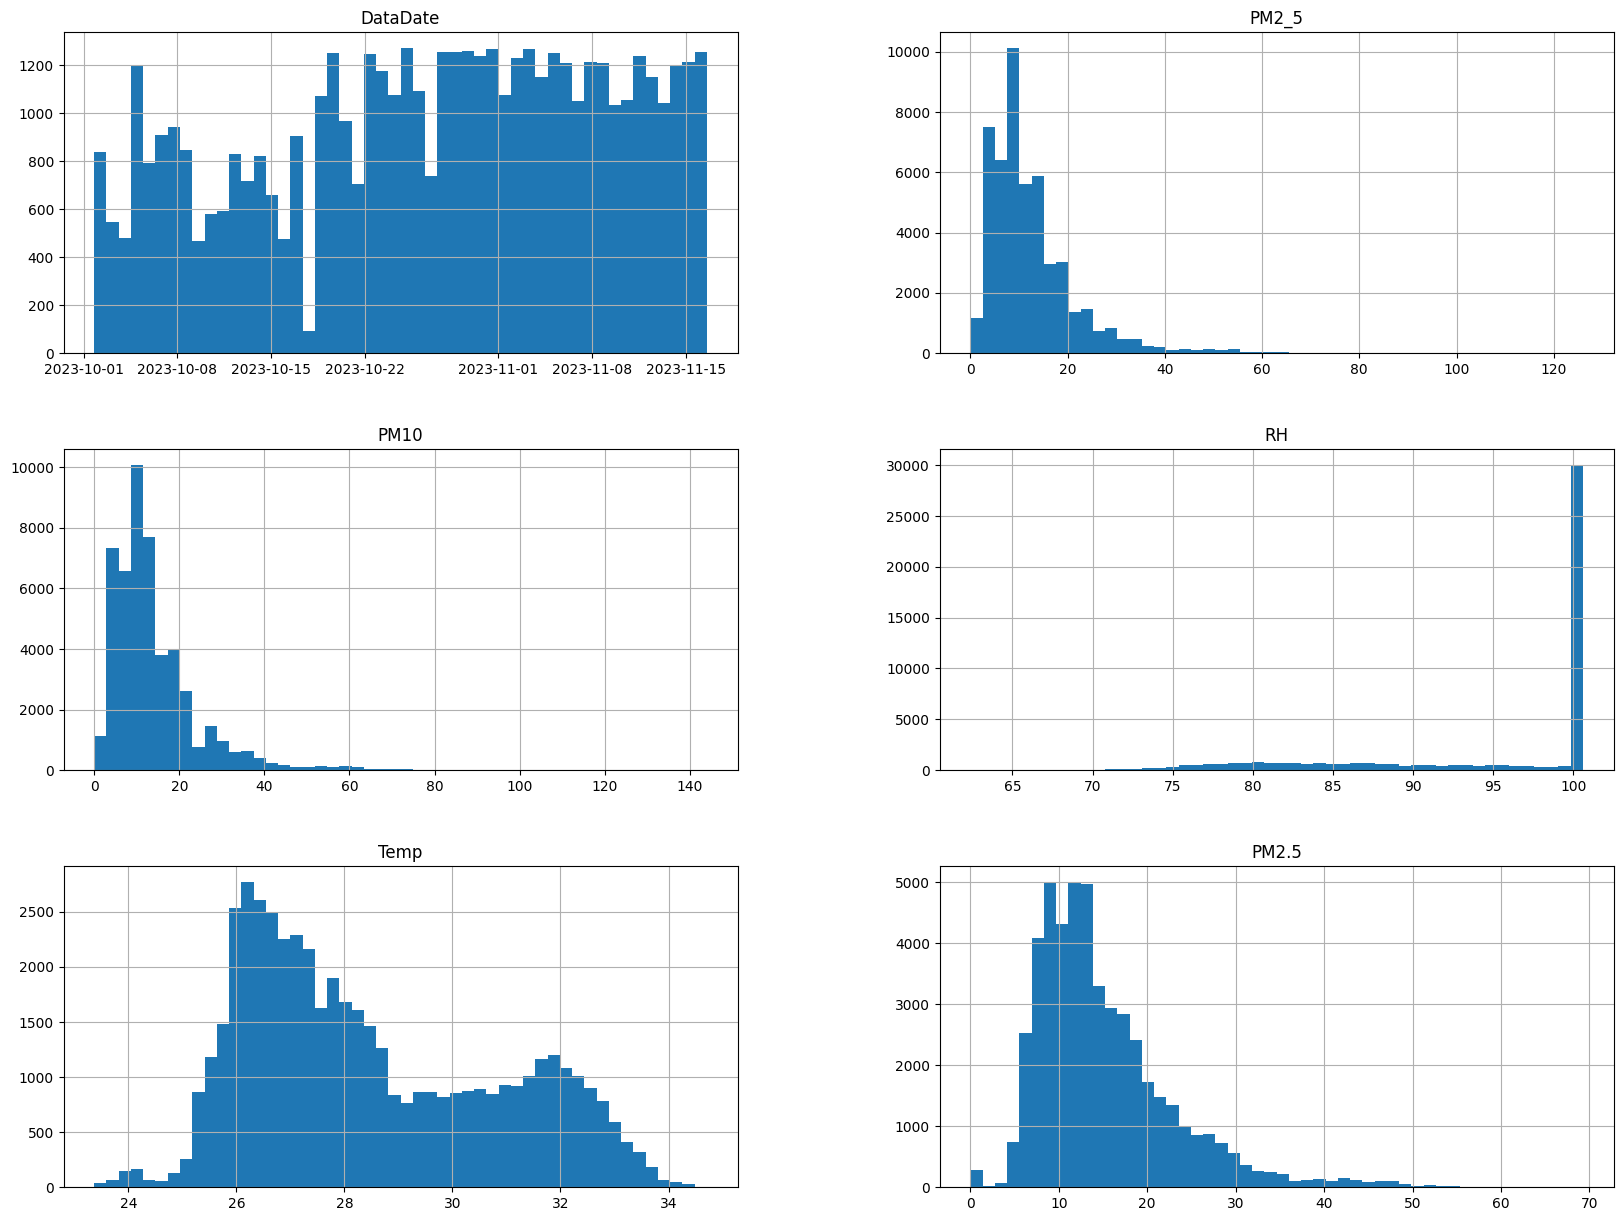

In [12]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
plt.show()

In [13]:
corr_matrix = df.corr()
corr_matrix['PM2_5']

DataDate    0.072721
PM2_5       1.000000
PM10        0.999155
RH          0.222628
Temp       -0.269943
PM2.5       0.900851
Name: PM2_5, dtype: float64

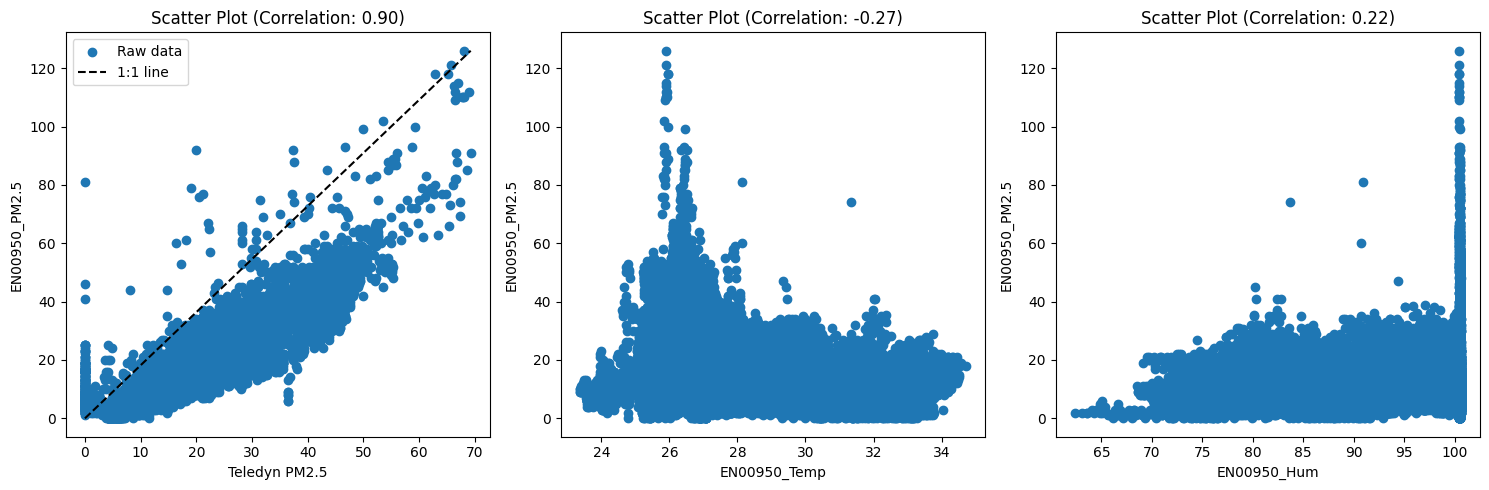

In [14]:
def correlation_scatter_plot_fxn(df, sensor_id):
    correlation_PM2_5 = df['PM2_5'].corr(df['PM2.5'])
    correlation_PM2_5_and_Temp = df['PM2_5'].corr(df['Temp'])
    correlation_PM2_5_and_Hum = df['PM2_5'].corr(df['RH'])
    

    # Create a figure with three subplots in one row and three columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first scatter plot
    axes[0].scatter(df['PM2.5'], df['PM2_5'], label='Raw data')
    axes[0].plot([min(df['PM2.5']), max(df['PM2.5'])], [min(df['PM2_5']), max(df['PM2_5'])],
                 color='black', linestyle='--', label='1:1 line')
    axes[0].set_xlabel('Teledyn PM2.5')
    axes[0].set_ylabel(f'{sensor_id}_PM2.5')
    axes[0].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5:.2f})')
    axes[0].legend()

    # Plot the second scatter plot
    axes[1].scatter(df['Temp'], df['PM2_5'])
    axes[1].set_xlabel(f'{sensor_id}_Temp')
    axes[1].set_ylabel(f'{sensor_id}_PM2.5')
    axes[1].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5_and_Temp:.2f})')

    # Plot the third scatter plot
    axes[2].scatter(df['RH'], df['PM2_5'])
    axes[2].set_xlabel(f'{sensor_id}_Hum')
    axes[2].set_ylabel(f'{sensor_id}_PM2.5')
    axes[2].set_title(f'Scatter Plot (Correlation: {correlation_PM2_5_and_Hum:.2f})')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


    #     plt.scatter(df['Temp'], df['TEMP'])
    #     plt.xlabel('Sensor Temp')
    #     plt.ylabel('Teledyne TEMP')
    #     plt.title(f'Scatter Plot (Correlation: {correlation_TEMP_and_Temp:.2f})')
    #     plt.show()

correlation_scatter_plot_fxn(df, 'EN00950')

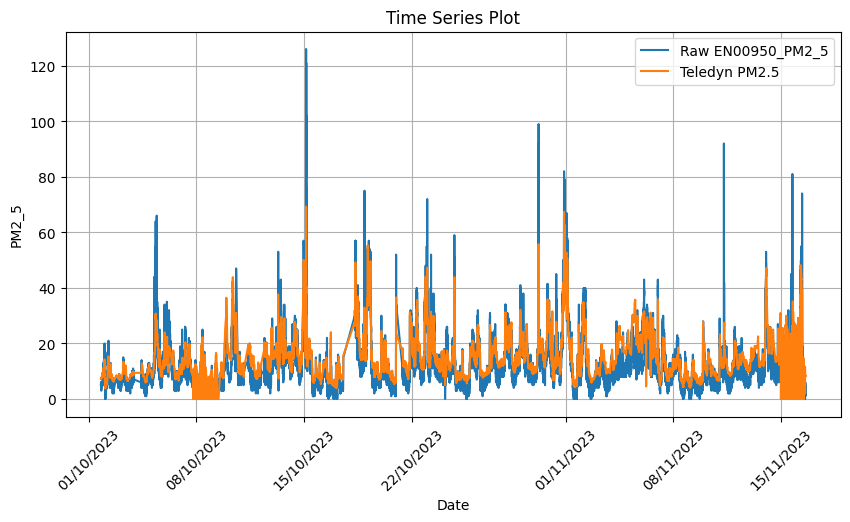

In [16]:
def plot_line_chart(df, sensor_id):
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=df['DataDate'], y=df['PM2_5'], label=f'Raw {sensor_id}_PM2_5')
    sns.lineplot(x=df['DataDate'], y=df['PM2.5'], label='Teledyn PM2.5')

    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('PM2_5')
    plt.grid(True)
    plt.legend()

    # Format the date on the x-axis to show hours and minutes (H:S)
    date_format = DateFormatter("%d/%m/%Y")
    plt.gca().xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()
plot_line_chart(df, 'EN00950')